# Fundamentos de analítica 2 (clase 4)

## Diego Fernando Agudelo
## Universidad ICESI
## diegoagudelo30@gmail.com\

## **1. Carga de paquetes**

In [ ]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.4 MB/s eta 0:00:00


## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [ ]:
data = pd.read_excel("/content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


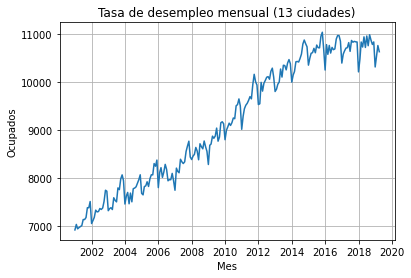

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

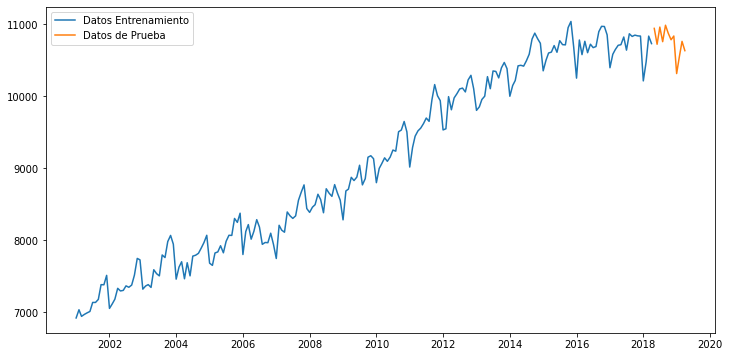

In [ ]:
train_len = 208
train_o = data[["Ocupados"]][:train_len]
test_o = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_o,label="Datos Entrenamiento")
plt.plot(test_o,label="Datos de Prueba")
plt.legend()
plt.show()

## **3. Optimización Bayesiana**

In [ ]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """

    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_o["Ocupados"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(12)
    rmse = np.sqrt(mean_squared_error(test_o["Ocupados"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [ ]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [ ]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
0.00011437481734488664 0.1846771895375956 0.2935117816342261
0.42 0.72 0.31
 target es: 927.5487253080397,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -927.5    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
0.39676747423066994 1.370439000793519 0.8383890288065896
0.19 0.35 0.54
 target es: 10223.012124968964,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -1.022e+0 | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
0.027387593197926163 1.1173796568915033 0.8346096047342539
0.21 0.87 0.67
 target es: 232243.5385763226,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, G

In [ ]:
optimizer.max

{'target': -117.66643248793336,
 'params': {'alpha': 0.13094541835039025,
  'beta': 0.1703895114195003,
  'error': 0.5677980381415073,
  'gamma': 0.1533273729799859,
  'seasonal': 0.2541486120351484,
  'trend': 1.9406834156907515}}

## **4. Parcial final**

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos


